In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

## Read in training data

In [16]:
TRAINING_DATASET = "tap_fun_train.csv"

In [17]:
training_df = pd.read_csv("./data/" + TRAINING_DATASET)

In [20]:
training_df.columns.values, len(training_df.columns.values)

(array(['user_id', 'register_time', 'wood_add_value', 'wood_reduce_value',
        'stone_add_value', 'stone_reduce_value', 'ivory_add_value',
        'ivory_reduce_value', 'meat_add_value', 'meat_reduce_value',
        'magic_add_value', 'magic_reduce_value', 'infantry_add_value',
        'infantry_reduce_value', 'cavalry_add_value',
        'cavalry_reduce_value', 'shaman_add_value', 'shaman_reduce_value',
        'wound_infantry_add_value', 'wound_infantry_reduce_value',
        'wound_cavalry_add_value', 'wound_cavalry_reduce_value',
        'wound_shaman_add_value', 'wound_shaman_reduce_value',
        'general_acceleration_add_value',
        'general_acceleration_reduce_value',
        'building_acceleration_add_value',
        'building_acceleration_reduce_value',
        'reaserch_acceleration_add_value',
        'reaserch_acceleration_reduce_value',
        'training_acceleration_add_value',
        'training_acceleration_reduce_value',
        'treatment_acceleraion_add_valu

In [19]:
training_df.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price
0,1,2018-02-02 19:47:15,20125.0,3700.0,0.0,0.0,0.0,0.0,16375.0,2000.0,...,0,0,0,0,0,0,0.333333,0.0,0,0.0
1,1593,2018-01-26 00:01:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.333333,0.0,0,0.0
2,1594,2018-01-26 00:01:58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1.166667,0.0,0,0.0
3,1595,2018-01-26 00:02:13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,3.166667,0.0,0,0.0
4,1596,2018-01-26 00:02:46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,2.333333,0.0,0,0.0


## Check spender vs. non-spender by D45

In [ ]:
## Label spender and non-spender
training_df['spender_label'] = training_df.apply(
    lambda row: 'spender' if row['prediction_pay_price'] > 0 else 'non-spender',
    axis=1
)

In [ ]:
training_df.groupby('spender_label')['user_id'].agg('count')

## Plot histogram of spenders (for a specific spending range)

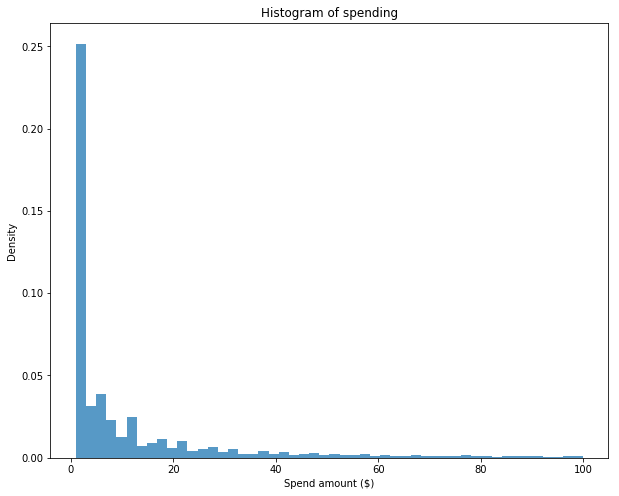

In [22]:
spend_lower = 0
spend_upper = 100

plt.figure(figsize=(10,8))

n, bins, patches = plt.hist(training_df[(training_df['prediction_pay_price'] > spend_lower) 
                                        & (training_df['prediction_pay_price'] <= spend_upper)].prediction_pay_price, 
                            50, density=True, alpha=0.75)

plt.xlabel('Spend amount ($)')
plt.ylabel('Density')
plt.title('Histogram of spending')
plt.show()

## Predicting spender/non-spender 

### Getting data ready for TensorFlow

In [15]:
from tensorflow import keras

# Helper libraries
import numpy as np
from sklearn.model_selection import train_test_split

In [31]:
## Working with training data only
X_havespent = training_df.iloc[:,2:108]
y_havespent = training_df.prediction_pay_price-training_df.pay_price>0

## Make train and test data sets
X, X_val, y, y_val = train_test_split(X_havespent, y_havespent, test_size=0.2, stratify=y_havespent)

### Building the model

In [32]:
model = keras.Sequential()
model.add(keras.layers.Embedding(2000, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          32000     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 32,289
Trainable params: 32,289
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Traing the model

In [34]:
history = model.fit(X,
                    y,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Train on 1830405 samples, validate on 457602 samples
Epoch 1/40


InvalidArgumentError: indices[259,0] = 2736160 is not in [0, 2000)
	 [[Node: embedding_2/GatherV2 = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_2/embeddings/read, embedding_2/Cast, embedding_2/GatherV2/axis)]]

Caused by op 'embedding_2/GatherV2', defined at:
  File "/Users/Minshen/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Minshen/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-c8aaae2ffa73>", line 2, in <module>
    model.add(keras.layers.Embedding(2000, 16))
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/_impl/keras/engine/sequential.py", line 164, in add
    layer(x)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/_impl/keras/engine/base_layer.py", line 314, in __call__
    output = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 717, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/_impl/keras/layers/embeddings.py", line 158, in call
    out = array_ops.gather(self.embeddings, inputs)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 2736, in gather
    return gen_array_ops.gather_v2(params, indices, axis, name=name)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3065, in gather_v2
    "GatherV2", params=params, indices=indices, axis=axis, name=name)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/Users/Minshen/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): indices[259,0] = 2736160 is not in [0, 2000)
	 [[Node: embedding_2/GatherV2 = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_2/embeddings/read, embedding_2/Cast, embedding_2/GatherV2/axis)]]
